In [1]:
import tqdm

In [2]:
import torch
import tensorrt as trt
from torch2trt import TRTModule

with trt.Logger() as logger, trt.Runtime(logger) as runtime:
    with open("../data/mobile_sam_image_encoder.engine", 'rb') as f:
        engine_bytes = f.read()
    engine = runtime.deserialize_cuda_engine(engine_bytes)

input_name = engine.get_binding_name(0)
output_name = engine.get_binding_name(1)

image_encoder_trt = TRTModule(
    engine=engine,
    input_names=[engine.get_binding_name(0)],
    output_names=[engine.get_binding_name(1)]
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3586925/3356628120.py:10: DeprecationWarning: Use get_tensor_name instead.
  input_name = engine.get_binding_name(0)
/tmp/ipykernel_3586925/3356628120.py:11: DeprecationWarning: Use get_tensor_name instead.
  output_name = engine.get_binding_name(1)
/tmp/ipykernel_3586925/3356628120.py:15: DeprecationWarning: Use get_tensor_name instead.
  input_names=[engine.get_binding_name(0)],
/tmp/ipykernel_3586925/3356628120.py:16: DeprecationWarning: Use get_tensor_name instead.
  output_names=[engine.get_binding_name(1)]


In [3]:
image_tensor = torch.randn(16, 3, 1024, 1024).cuda()

In [4]:
features = image_encoder_trt(image_tensor)

In [14]:
import torch.nn as nn
from typing import Tuple
import timm
class ImageEncoderCNN(nn.Module):
    def __init__(self, 
            model_name: str,
            pretrained: bool = False,
            feature_dim: int = 256,
            feature_shape: Tuple[int, int] = (64, 64),
            pos_embedding: bool = True):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True
        )

        self.up_1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.up_2 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, 2, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.proj = nn.Conv2d(
            256 + 128, 
            feature_dim, 
            3,
            padding=1
        )

        if pos_embedding:
            self.register_parameter(
                "pos_embedding", 
                nn.Parameter(1e-5*torch.randn(1, feature_dim, *feature_shape))
            )
        else:
            self.pos_embedding = None
        
        
    def forward(self, x):
        x = self.backbone(x)
        z = torch.cat([x[-2], self.up_1(x[-1])], dim=1)
        z = torch.cat([x[-3], self.up_2(z)], dim=1)
        x = self.proj(z)
        if self.pos_embedding is not None:
            x = x + self.pos_embedding
        return x


image_encoder_cnn = ImageEncoderCNN("resnet18", pretrained=True).cuda()

/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


In [19]:
optimizer = torch.optim.Adam(image_encoder_cnn.parameters(), lr=3e-4)

In [20]:
import glob
from typing import Optional
import os
import matplotlib.pyplot as plt
from torchvision.transforms import RandomResizedCrop, ToTensor, Normalize, Compose
import PIL.Image
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

transform = Compose([
    RandomResizedCrop((1024, 1024)),
    ToTensor(),
    Normalize(
        mean=[123.675/255, 116.28/255, 103.53/255],
        std=[58.395/255, 57.12/255, 57.375/255]
    )
])

class ImageDataset:
    def __init__(self, root: str, transform):
        self.root = root
        image_paths = glob.glob(os.path.join(root, "*.jpg"))
        image_paths += glob.glob(os.path.join(root, "*.png"))
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = PIL.Image.open(self.image_paths[index]).convert("RGB")
        image = self.transform(image)
        return image
    
dataset = ImageDataset("../data/coco/train2017/", transform)

dataset, _ = random_split(dataset, [10000, len(dataset) - 10000])

loader = DataLoader(dataset, shuffle=True, batch_size=16, num_workers=8)

100%|██████████| 625/625 [04:05<00:00,  2.55it/s]


0 - 0.0011900928920134902


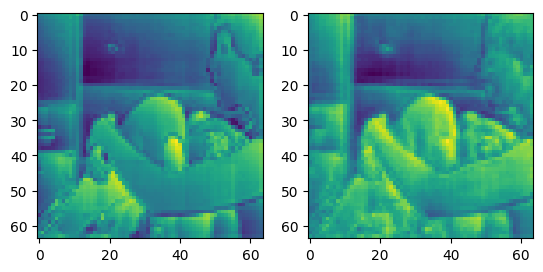

100%|██████████| 625/625 [04:05<00:00,  2.55it/s]


1 - 0.0011337103783152997


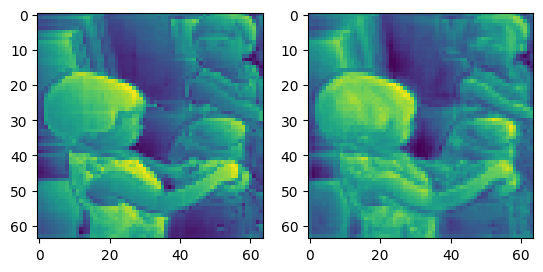

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


2 - 0.0010875187653116881


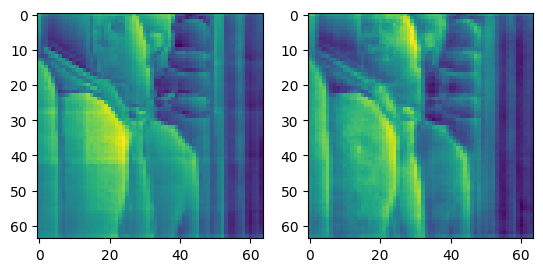

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


3 - 0.0010801066267304123


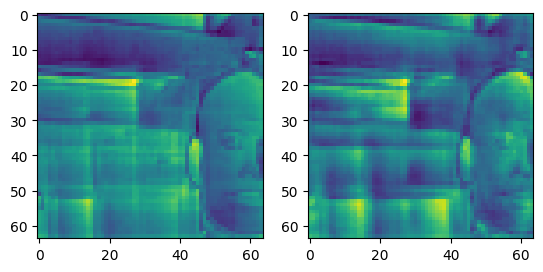

100%|██████████| 625/625 [04:06<00:00,  2.54it/s]


4 - 0.0010319756355136633


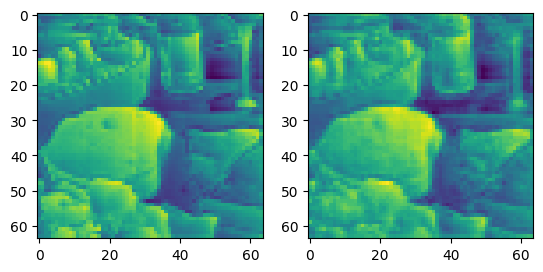

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


5 - 0.001005340091418475


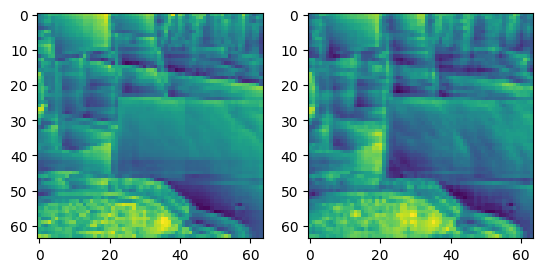

100%|██████████| 625/625 [04:05<00:00,  2.55it/s]


6 - 0.0009796260572969913


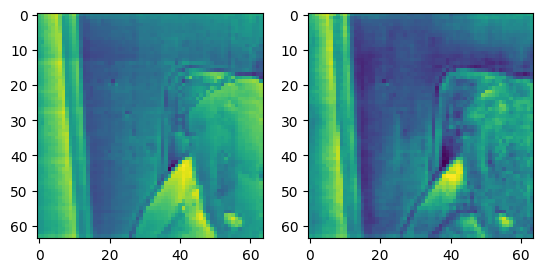

100%|██████████| 625/625 [04:05<00:00,  2.55it/s]


7 - 0.000954465149063617


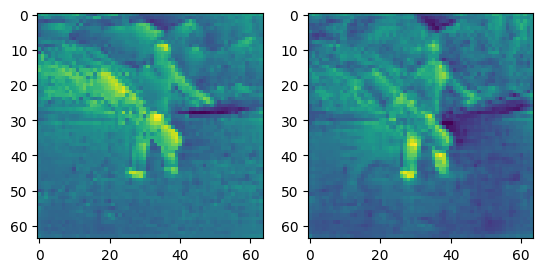

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


8 - 0.0009336556725203991


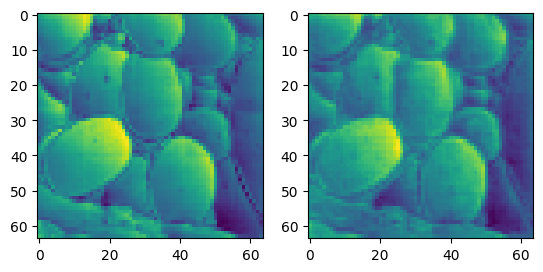

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


9 - 0.0009200500385835767


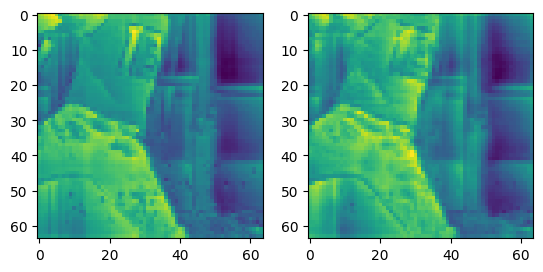

100%|██████████| 625/625 [04:05<00:00,  2.54it/s]


10 - 0.0008961345706135034


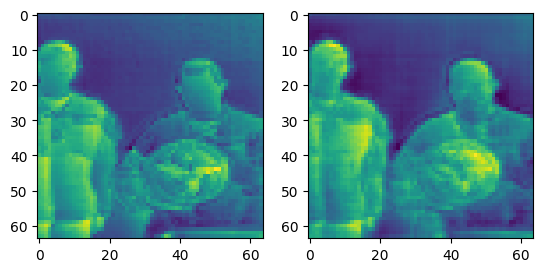

100%|██████████| 625/625 [04:06<00:00,  2.54it/s]


11 - 0.0008855510815046727


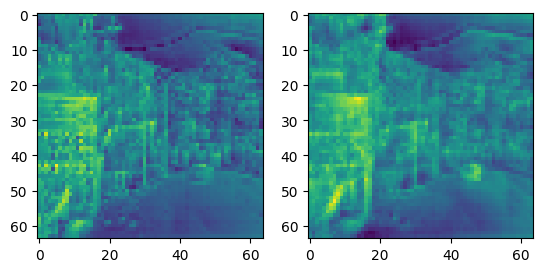

 18%|█▊        | 114/625 [00:46<03:26,  2.47it/s]


KeyboardInterrupt: 

In [22]:
for epoch in range(200):
    epoch_loss = 0.
    for image in tqdm.tqdm(iter(loader)):
        image = image.cuda()
        if len(image) != 16:
            continue
        image_cnn = F.interpolate(image, (512, 512), mode="area")
        with torch.no_grad():
            features = image_encoder_trt(image)

        optimizer.zero_grad()
        output = image_encoder_cnn(image_cnn)

        loss = F.huber_loss(output, features)
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss)
    epoch_loss /= len(loader)
    print(f"{epoch} - {epoch_loss}")

    torch.save({
        "model": image_encoder_cnn.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch}, "data/models/resnet18/checkpoint.pth")
        
    plt.subplot(121)
    plt.imshow(features[0, 0].detach().cpu())
    plt.subplot(122)
    plt.imshow(output[0, 0].detach().cpu())
    plt.show()

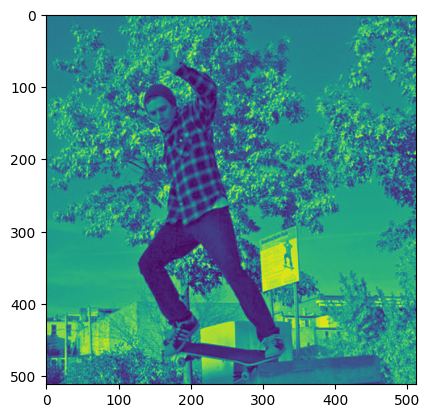

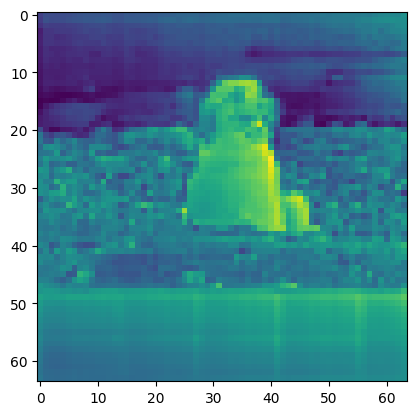

In [6]:
plt.imshow(features[0,0].detach().cpu())